In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Ustawienia Danych i Pobieranie
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'AMD', 'ADM', 'NVDA', 'GOOG', 'DB', 'GS', 'BABA', 'BA', 'PYPL', 'GRMN', 'NFLX', 'UBER', 'WMT']
start_date = '2020-01-01'
end_date = '2024-12-31'
risk_free_rate = 0.0575  # Przyjęta roczna stopa wolna od ryzyka - rentowność rocznych polskich obligacji (18-11-2025)
train_split_ratio = 0.8  # 80% danych na zbiór treningowy (optymalizacja)

# Pobieranie pełnego zestawu danych
full_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close'].dropna()
log_returns_full = np.log(full_data / full_data.shift(1)).dropna()

[*********************100%***********************]  18 of 18 completed


In [3]:
# Podział Danych (Train/Test Split)
split_point = int(len(log_returns_full) * train_split_ratio)

# Dane IN-SAMPLE (do optymalizacji)
log_returns_train = log_returns_full.iloc[:split_point]

# Dane OUT-OF-SAMPLE (do testowania)
log_returns_test = log_returns_full.iloc[split_point:]

print(f"Dane treningowe (optymalizacja): od {log_returns_train.index.min().date()} do {log_returns_train.index.max().date()}")
print(f"Dane testowe (ocena): od {log_returns_test.index.min().date()} do {log_returns_test.index.max().date()}\n")

Dane treningowe (optymalizacja): od 2020-01-03 do 2023-12-28
Dane testowe (ocena): od 2023-12-29 do 2024-12-30



In [4]:
# Funkcje Metryk Portfela

def portfolio_annual_returns(weights, log_returns):
    """Oblicza roczną oczekiwaną stopę zwrotu (252 dni handlowe)."""
    return np.sum(log_returns.mean() * weights) * 252

def portfolio_annual_variance(weights, log_returns):
    """Oblicza roczną wariancję (ryzyko)."""
    return np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))

def portfolio_sharpe_ratio(weights, log_returns, rf=risk_free_rate):
    """Oblicza wskaźnik Sharpe'a."""
    returns = portfolio_annual_returns(weights, log_returns)
    volatility = np.sqrt(portfolio_annual_variance(weights, log_returns))
    if volatility == 0:
        return 0
    return (returns - rf) / volatility

def negative_sharpe_ratio(weights, log_returns):
    """Funkcja do minimalizacji (Max Sharpe = Min (-Sharpe))."""
    return -portfolio_sharpe_ratio(weights, log_returns)

# Ograniczenia i warunki początkowe
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}) # Suma wag = 1
bounds = tuple((0, 1) for _ in range(len(tickers))) # Wagi od 0 do 1 (brak krótkiej sprzedaży)
initial_weights = np.array([1/len(tickers)] * len(tickers))

In [5]:
# Optymalizacja (Tylko na Danych Treningowych)

num_assets = len(tickers)

# Ograniczenie: suma wag = 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Ograniczenie: brak short selling – każda waga pomiędzy 0 a 35

bounds = tuple((0, 0.35) for _ in range(num_assets))   # max 35% na spółkę

initial_weights = np.array(num_assets * [1/num_assets])

# Portfel o Maksymalnym Wskaźniku Sharpe'a (Max Sharpe)
opt_sharpe = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(log_returns_train,),  # Używam tylko danych treningowych
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
max_sharpe_weights = opt_sharpe.x

# Portfel o Minimalnej Wariancji (Min Vol)
opt_variance = minimize(
    portfolio_annual_variance,
    initial_weights,
    args=(log_returns_train,),  # Używam tylko danych treningowych
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
min_vol_weights = opt_variance.x

In [6]:
# Wyniki Optymalizacji (In-Sample)
print("\n--- Metryki IN-SAMPLE (Oczekiwane) ---")

# Max Sharpe IN-SAMPLE
ret_sharpe_in = portfolio_annual_returns(max_sharpe_weights, log_returns_train)
vol_sharpe_in = np.sqrt(portfolio_annual_variance(max_sharpe_weights, log_returns_train))
sharpe_in = portfolio_sharpe_ratio(max_sharpe_weights, log_returns_train)

print(f"Max Sharpe (IN-SAMPLE) - Wagi: {pd.Series(max_sharpe_weights, index=tickers).map('{:.1%}'.format)}")
print(f"Zwrot: {ret_sharpe_in:.2%}, Ryzyko (Vol): {vol_sharpe_in:.2%}, Sharpe Ratio:: {sharpe_in:.2f}")

# Min Vol IN-SAMPLE
ret_vol_in = portfolio_annual_returns(min_vol_weights, log_returns_train)
vol_vol_in = np.sqrt(portfolio_annual_variance(min_vol_weights, log_returns_train))
sharpe_vol_in = portfolio_sharpe_ratio(min_vol_weights, log_returns_train)

print(f"\nMin Vol (IN-SAMPLE) - Wagi: {pd.Series(min_vol_weights, index=tickers).map('{:.1%}'.format)}")
print(f"Zwrot: {ret_vol_in:.2%}, Ryzyko (Vol): {vol_vol_in:.2%}, Sharpe Ratio: {sharpe_vol_in:.2f}\n")


--- Metryki IN-SAMPLE (Oczekiwane) ---
Max Sharpe (IN-SAMPLE) - Wagi: AAPL     12.7%
MSFT     19.2%
GOOGL     0.0%
AMZN      0.0%
TSLA      0.0%
AMD       0.0%
ADM       0.0%
NVDA      0.0%
GOOG      0.0%
DB        0.0%
GS        0.0%
BABA      0.0%
BA        0.0%
PYPL     35.0%
GRMN      0.0%
NFLX     32.9%
UBER      0.0%
WMT       0.2%
dtype: object
Zwrot: 42.34%, Ryzyko (Vol): 41.38%, Sharpe Ratio:: 0.88

Min Vol (IN-SAMPLE) - Wagi: AAPL      0.0%
MSFT     27.0%
GOOGL     0.0%
AMZN      5.6%
TSLA      0.0%
AMD       5.8%
ADM       0.0%
NVDA      3.5%
GOOG      2.3%
DB       19.2%
GS        0.0%
BABA      0.0%
BA        1.6%
PYPL      0.0%
GRMN      0.0%
NFLX      0.0%
UBER      0.0%
WMT      35.0%
dtype: object
Zwrot: 8.89%, Ryzyko (Vol): 20.15%, Sharpe Ratio: 0.16



In [7]:
# Ocena Portfeli na Danych Testowych (Out-of-Sample)
print("## 🛡️ Ocena OUT-OF-SAMPLE (Zrealizowane) ---")

# A. Ocena portfela Max Sharpe (wagi z TRAIN, zwroty z TEST)
ret_sharpe_out = portfolio_annual_returns(max_sharpe_weights, log_returns_test)
vol_sharpe_out = np.sqrt(portfolio_annual_variance(max_sharpe_weights, log_returns_test))
sharpe_out = portfolio_sharpe_ratio(max_sharpe_weights, log_returns_test)

print("--- Portfel MAX SHARPE (Wagi z TRAIN) ---")
print(f"Zrealizowany Zwrot (TEST): {ret_sharpe_out:.2%}")
print(f"Zrealizowane Ryzyko (TEST): {vol_sharpe_out:.2%}")
print(f"Zrealizowany Sharpe (TEST): {sharpe_out:.2f}")

## 🛡️ Ocena OUT-OF-SAMPLE (Zrealizowane) ---
--- Portfel MAX SHARPE (Wagi z TRAIN) ---
Zrealizowany Zwrot (TEST): 49.34%
Zrealizowane Ryzyko (TEST): 32.76%
Zrealizowany Sharpe (TEST): 1.33


In [8]:
# Ocena portfela Min Vol (wagi z TRAIN, zwroty z TEST)
ret_vol_out = portfolio_annual_returns(min_vol_weights, log_returns_test)
vol_vol_out = np.sqrt(portfolio_annual_variance(min_vol_weights, log_returns_test))
sharpe_vol_out = portfolio_sharpe_ratio(min_vol_weights, log_returns_test)

print("\n--- Portfel MIN VOL (Wagi z TRAIN) ---")
print(f"Zrealizowany Zwrot (TEST): {ret_vol_out:.2%}")
print(f"Zrealizowane Ryzyko (TEST): {vol_vol_out:.2%}")
print(f"Zrealizowany Sharpe (TEST): {sharpe_vol_out:.2f}")


--- Portfel MIN VOL (Wagi z TRAIN) ---
Zrealizowany Zwrot (TEST): 25.51%
Zrealizowane Ryzyko (TEST): 15.04%
Zrealizowany Sharpe (TEST): 1.31


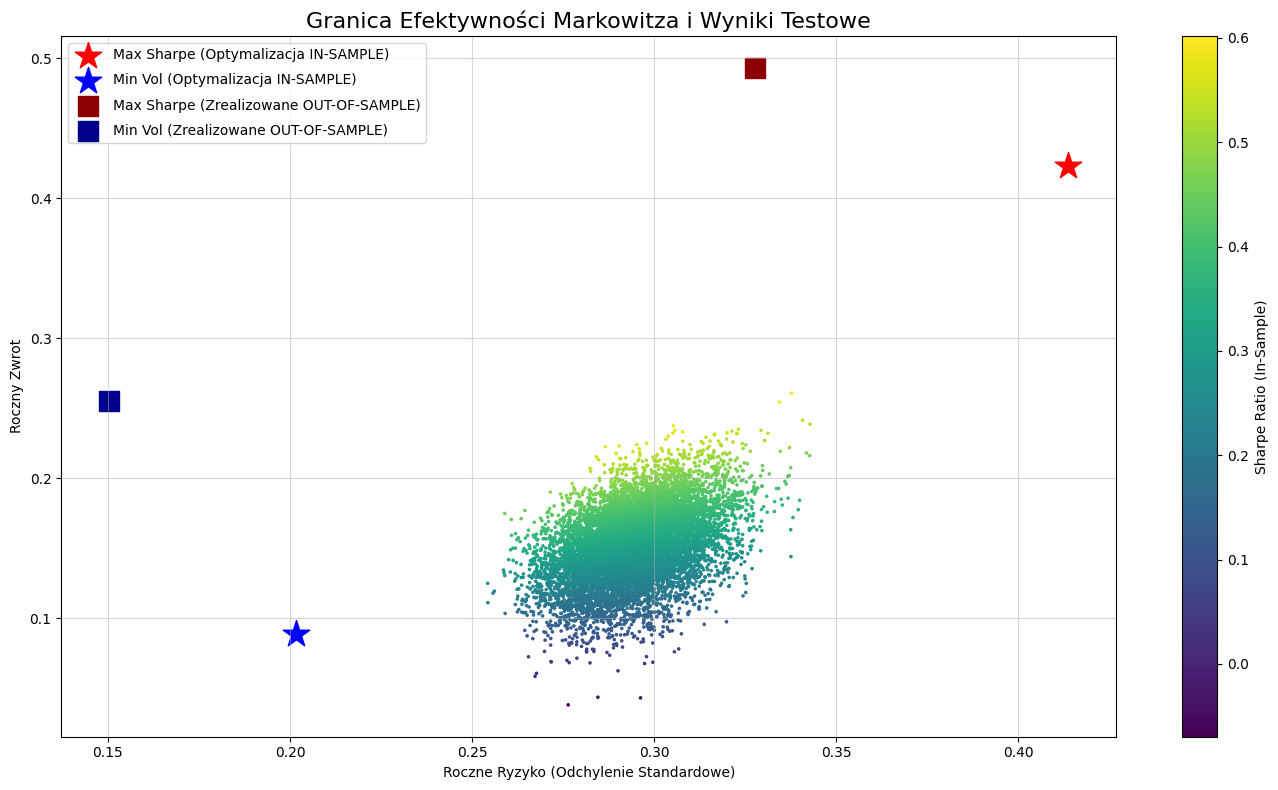

In [19]:
# Symulacja Losowych Portfeli (Tylko na Danych Treningowych)
num_portfolios = 10000
results = np.zeros((3, num_portfolios)) # Sharpe, Zwrot, Volatility

for i in range(num_portfolios):
    # Generowanie losowych wag
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    # Obliczenia na DANYCH TRENINGOWYCH
    port_returns = portfolio_annual_returns(weights, log_returns_train)
    port_volatility = np.sqrt(portfolio_annual_variance(weights, log_returns_train))
    sharpe_ratio = portfolio_sharpe_ratio(weights, log_returns_train)

    results[0, i] = sharpe_ratio
    results[1, i] = port_returns
    results[2, i] = port_volatility

# Zapisanie wyników jako DataFrame
results_frame = pd.DataFrame(results.T, columns=['Sharpe', 'Returns', 'Volatility'])

# Definiowanie punktów optymalnych i testowych ---

# Punkty IN-SAMPLE (optymalne w okresie treningowym)
max_sharpe_point = (vol_sharpe_in, ret_sharpe_in)
min_vol_point = (vol_vol_in, ret_vol_in)

# Punkty OUT-OF-SAMPLE (zrealizowane w okresie testowym)
max_sharpe_test_point = (vol_sharpe_out, ret_sharpe_out)
min_vol_test_point = (vol_vol_out, ret_vol_out)

# Rysowanie wykresu Granicy Efektywności
plt.figure(figsize=(14, 8))

# Losowe Portfele (Granica Efektywności)
plt.scatter(results_frame.Volatility, results_frame.Returns, c=results_frame.Sharpe, cmap='viridis', marker='.', s=10)
plt.colorbar(label='Sharpe Ratio (In-Sample)')
plt.title('Granica Efektywności Markowitza i Wyniki Testowe', fontsize=16)
plt.xlabel('Roczne Ryzyko (Odchylenie Standardowe)')
plt.ylabel('Roczny Zwrot')

# Portfele Optymalne IN-SAMPLE (Gwiazdki)
plt.scatter(max_sharpe_point[0], max_sharpe_point[1], marker='*', color='red', s=400, label='Max Sharpe (Optymalizacja IN-SAMPLE)')
plt.scatter(min_vol_point[0], min_vol_point[1], marker='*', color='blue', s=400, label='Min Vol (Optymalizacja IN-SAMPLE)')

# Zrealizowane Wyniki OUT-OF-SAMPLE (Kwadraty)
plt.scatter(max_sharpe_test_point[0], max_sharpe_test_point[1], marker='s', color='darkred', s=200, label='Max Sharpe (Zrealizowane OUT-OF-SAMPLE)')
plt.scatter(min_vol_test_point[0], min_vol_test_point[1], marker='s', color='darkblue', s=200, label='Min Vol (Zrealizowane OUT-OF-SAMPLE)')

plt.legend(labelspacing=0.8, loc='best')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [10]:
# Porównanie i Wizualizacja Granicy Efektywności

data_compare = {
    'Max Sharpe': [ret_sharpe_in, vol_sharpe_in, sharpe_in, ret_sharpe_out, vol_sharpe_out, sharpe_out],
    'Min Vol': [ret_vol_in, vol_vol_in, sharpe_vol_in, ret_vol_out, vol_vol_out, sharpe_vol_out]
}

df_compare = pd.DataFrame(data_compare, index=[
    'Zwrot (Train)', 'Ryzyko (Train)', 'Sharpe (Train)',
    'Zwrot (Test)', 'Ryzyko (Test)', 'Sharpe (Test)'
])

print("\n## 📋 Tabela Porównawcza (In-Sample vs Out-of-Sample)")
print(df_compare.applymap(lambda x: f'{x:.2f}' if abs(x) > 1 else f'{x:.2%}'))


## 📋 Tabela Porównawcza (In-Sample vs Out-of-Sample)
               Max Sharpe Min Vol
Zwrot (Train)      42.34%   8.89%
Ryzyko (Train)     41.38%  20.15%
Sharpe (Train)     88.41%  15.57%
Zwrot (Test)       49.34%  25.51%
Ryzyko (Test)      32.76%  15.04%
Sharpe (Test)        1.33    1.31


/var/folders/_k/2cy41vg9479_m__hn_x4sy9m0000gn/T/ipykernel_11077/1191262352.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df_compare.applymap(lambda x: f'{x:.2f}' if abs(x) > 1 else f'{x:.2%}'))


In [11]:
# Pobranie danych z benchmarku
benchmark = yf.download("^GSPC", start=log_returns_full.index.min(), end=log_returns_full.index.max(), auto_adjust=True)["Close"]
benchmark_returns = np.log(benchmark / benchmark.shift(1)).dropna()


[*********************100%***********************]  1 of 1 completed


In [12]:
benchmark_aligned = benchmark_returns.reindex(log_returns_full.index, method="ffill")


In [13]:
benchmark_train = benchmark_aligned.iloc[:split_point]
benchmark_test  = benchmark_aligned.iloc[split_point:]

In [14]:
bench_mu_test    = benchmark_test.mean() * 252
bench_sigma_test = benchmark_test.std() * np.sqrt(252)
bench_sharpe_test = (bench_mu_test - risk_free_rate) / bench_sigma_test

In [15]:
port_return_max_sharpe = ret_sharpe_out      # roczna stopa zwrotu
port_vol_max_sharpe    = vol_sharpe_out      # roczna zmienność
port_sharpe_max_sharpe = sharpe_out

In [16]:
port_return_min_vol    = ret_vol_out
port_vol_min_vol       = vol_vol_out
port_sharpe_min_vol    = sharpe_vol_out

In [17]:
print("\n=== PORÓWNANIE Z BENCHMARKIEM (TEST) ===")

print(f"Portfel Max Sharpe - zwrot: {float(port_return_max_sharpe):.2%}, "
      f"Sharpe: {float(port_sharpe_max_sharpe):.3f}")

print(f"Portfel Min Vol    - zwrot: {float(port_return_min_vol):.2%}, "
      f"Sharpe: {float(port_sharpe_min_vol):.3f}")

print(f"Benchmark S&P 500  - zwrot: {float(bench_mu_test):.2%}, "
      f"Sharpe: {float(bench_sharpe_test):.3f}")


=== PORÓWNANIE Z BENCHMARKIEM (TEST) ===
Portfel Max Sharpe - zwrot: 49.34%, Sharpe: 1.330
Portfel Min Vol    - zwrot: 25.51%, Sharpe: 1.314
Benchmark S&P 500  - zwrot: 21.06%, Sharpe: 1.209


/var/folders/_k/2cy41vg9479_m__hn_x4sy9m0000gn/T/ipykernel_11077/525267623.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Benchmark S&P 500  - zwrot: {float(bench_mu_test):.2%}, "
/var/folders/_k/2cy41vg9479_m__hn_x4sy9m0000gn/T/ipykernel_11077/525267623.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  f"Sharpe: {float(bench_sharpe_test):.3f}")


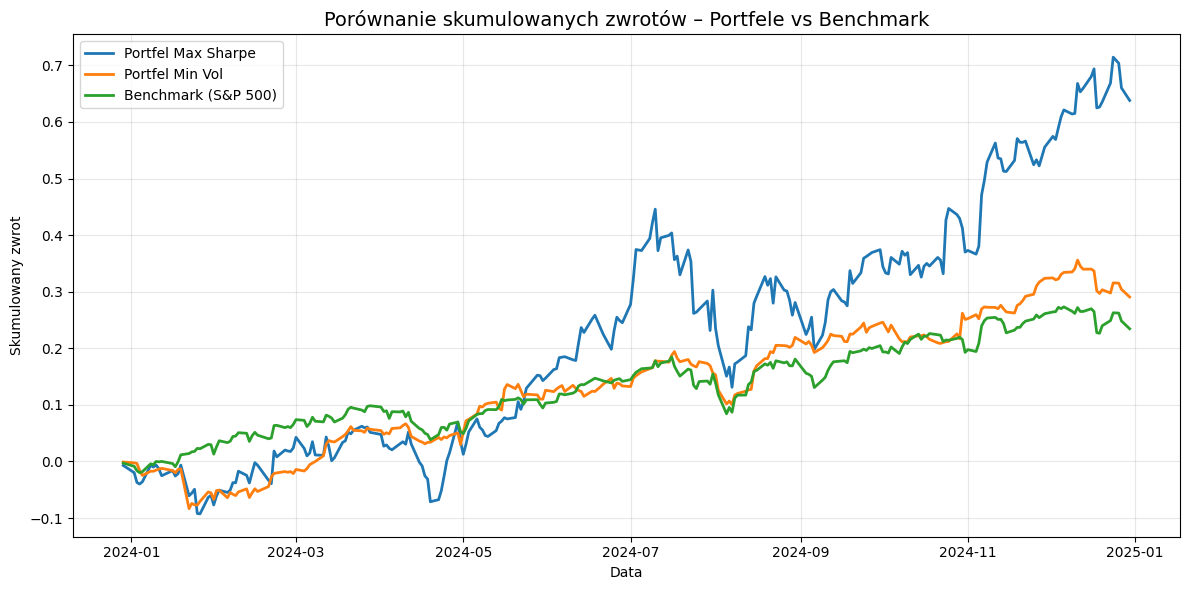

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# --- Log-zwroty (muszą mieć identyczny indeks dat!) ---
port_log_test_max = log_returns_test @ max_sharpe_weights
port_log_test_min = log_returns_test @ min_vol_weights
bench_log_test    = benchmark_aligned.iloc[split_point:]   # KLUCZOWE!

# --- Skumulowane zwroty ---
port_cum_max_curve = np.exp(port_log_test_max.cumsum()) - 1
port_cum_min_curve = np.exp(port_log_test_min.cumsum()) - 1
bench_cum_curve    = np.exp(bench_log_test.cumsum()) - 1

# --- Wykres ---
plt.figure(figsize=(12,6))
plt.plot(port_cum_max_curve, label="Portfel Max Sharpe", linewidth=2)
plt.plot(port_cum_min_curve, label="Portfel Min Vol", linewidth=2)
plt.plot(bench_cum_curve,    label="Benchmark (S&P 500)", linewidth=2)

plt.title("Porównanie skumulowanych zwrotów – Portfele vs Benchmark", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Skumulowany zwrot")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()